In [140]:
#pip install spotipy --upgrade              # Uncomment this and run it if you haven't installed spotipy before


In [3]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import clientID, clientSEC           # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [4]:
# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=clientID, client_secret=clientSEC)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [27]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

country_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up **main dataframe** with data from **FIRST** file
string = str(glob.glob(path)[0])                                 # in the folder.
year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
                                                                 # **file name**
country_tracks_df[['Year']] = year_month[0]
country_tracks_df[['Month']] = year_month[1]
country_tracks_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1]) 
Tot_Streams1 = country_tracks_df['Streams'].sum()                # Find out total streams in FIRST file in folder.
country_tracks_df[['Stream %']] = country_tracks_df['Streams'] / Tot_Streams1    # New column with % of streams

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        #print (year_month)
        Tot_Streams2 = temp_df['Streams'].sum()
        temp_df[['Year']] = year_month[0]
        temp_df[['Month']] = year_month[1]
        temp_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1])
        temp_df[['Stream %']] = temp_df['Streams'] / Tot_Streams2
        country_tracks_df = pd.concat([country_tracks_df,        # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.  ¿¿¿???? 
        

                                                 
country_tracks_df = country_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month




                                                                 # You should get 4,800 rows (24 months x 200 
                                                                 # tracks per month)
country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,01,2019-01,0.033085
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,01,2019-01,0.022878
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,01,2019-01,0.020325
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,01,2019-01,0.016500
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,01,2019-01,0.016227
...,...,...,...,...,...,...,...,...,...
195,196,goosebumps,Travis Scott,51789,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,2020,12,2020-12,0.002946
196,197,Thinking out Loud,Ed Sheeran,51607,https://open.spotify.com/track/1Slwb6dOYkBlWal...,2020,12,2020-12,0.002936
197,198,Santa Claus Is Coming To Town,The Jackson 5,51569,https://open.spotify.com/track/6a1hzBiTkgqTsDA...,2020,12,2020-12,0.002934
198,199,Take It Easy - 2013 Remaster,Eagles,51254,https://open.spotify.com/track/4yugZvBYaoREkJK...,2020,12,2020-12,0.002916


In [28]:
# Get Track IDs
track_names = country_tracks_df['Track Name'].to_list()           # Set up list of tracks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)                                   # nan if nothing

7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Better song ID : 6gdLyYNuhWBzqwlOFSsXC7
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
Shotgun song ID : 4ofwffwvvnbSkrMSCKQDaC
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
Giant (with Rag'n'Bone Man) song ID : 5itOtNx0WxtJmi1TQ3RuRd
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Soaked song ID : 4zIiarkbaDt2cm6sukb1Xt
Nothing Breaks Like a Heart (feat. Miley Cyrus) song ID : 27rdGxbavYJeBphck5MZAF
Close To Me (with Diplo) (f

I'm Yours song ID : 1EzrEOXmMH3G43AXT1y7pA
Suncity (feat. Empress Of) song ID : 6SkHm6poyKfzV6kc9any8k
Tennessee Whiskey song ID : 3fqwjXwUGN6vbzIwvyFMhx
Splashin song ID : 3KLo7ByvjCNyBrfz5DZ2mO
Brown Eyed Girl song ID : 3yrSvpt2l1xhsV9Em88Pul
Happy Now song ID : 4keoy2fqgwGnbWlm3ZVZFa
Born To Be Yours song ID : 0WVAQaxrT0wsGEG4BCVSn2
Castle on the Hill song ID : 6PCUP3dWmTjcTtXY02oFdT
1950 song ID : 0CZ8lquoTX2Dkg7Ak2inwA
Summer Of '69 song ID : 0GONea6G2XdnHWjNZd6zt3
Let Me Go (with Alesso, Florida Georgia Line & watt) song ID : 5Gu0PDLN4YJeW75PpBSg9p
No Stylist (feat. Drake) song ID : 04MLEeAMuV9IlHEsD8vF6A
IDGAF song ID : 76cy1WJvNGJTj78UqeA5zr
Trampoline song ID : 0lsRatBUs9HNIZAmoGABzk
Rocket Man (I Think It's Going To Be A Long, Long Time) song ID : 3gdewACMIVMEWVbyb8O9sY
First Off (feat. Travis Scott) song ID : 3WRIaWsws011vHMd9uzPjG
Party In The U.S.A. song ID : 5Q0Nhxo0l2bP3pNjpGJwV1
REEL IT IN song ID : 5qHirGR7M9tdm6C17DlzSY
I Found You (with Calvin Harris) song ID : 5sdb5

I Like It song ID : 58q2HKrzhC3ozto2nDdN4z
1999 song ID : 2QSUyofqpGDCo026OPiTBQ
Hotel California - 2013 Remaster song ID : 40riOy7x9W7GXjyGp4pjAv
Splashin song ID : 3KLo7ByvjCNyBrfz5DZ2mO
Under Pressure - Remastered 2011 song ID : 11IzgLRXV7Cgek3tEgGgjw
The Middle song ID : 6GG73Jik4jUlQCkKg9JuGO
Meant to Be (feat. Florida Georgia Line) song ID : 7iDa6hUg2VgEL1o1HjmfBn
Peer Pressure (feat. Julia Michaels) song ID : 2hFFke3WXVA9mV31XNy0dP
Falling Down - Bonus Track song ID : 4jvjzW7Hm0yK4LvvE0Paz9
Mr. Brightside song ID : 7oK9VyNzrYvRFo7nQEYkWN
Woke Up Late song ID : 4oPWkP9zQ5ANBbfdHGOvKF
Young Dumb & Broke song ID : 5Z3GHaZ6ec9bsiI5BenrbY
Armed And Dangerous song ID : 5wujBwqG7INdStqGd4tRMX
What A Time (feat. Niall Horan) song ID : 5WtfUKzXircvW8l5aaVZWT
Up There song ID : 2rKmNEYrQxaOPZrOWKZpOc
These Days (feat. Jess Glynne, Macklemore & Dan Caplen) song ID : 5CLGzJsGqhCEECcpnFQA8x
Love Lies (with Normani) song ID : 45Egmo7icyopuzJN0oMEdk
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Thu

bellyache song ID : 51NFxnQvaosfDDutk0tams
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Africa song ID : 2374M0fQpWi3dLnB54qaLX
Moonlight song ID : 0JP9xo3adEtGSdUEISiszL
Psycho (feat. Ty Dolla $ign) song ID : 3swc6WTsr7rl9DqQKQA55C
Drip Too Hard (Lil Baby & Gunna) song ID : 78QR3Wp35dqAhFEc2qAGjE
Look Back at It song ID : 3Ol2xnObFdKV9pmRD2t9x8
6 Figures song ID : 1Q8OgsmxcnoGev6T7KUenD
Last Hurrah song ID : 0i0wnv9UoFdZ5MfuFGQzMy
So Close song ID : 7FjZU7XFs7P9jHI9Z0yRhK
365 song ID : 2XWjPtKdi5sucFYtVav07d
Undecided song ID : 58oryymPZNdtS2z8Une6NJ
Don’t Give It Up song ID : 0gTJK4pCZMh8PxYdaAgf2B
Let You Love Me song ID : 5Fla3zyOCcIRqrDoKLU0DP
Dreams - 2004 Remaster song ID : 0ofHAoxe9vBkTCp2UQIavz
Don’t Forget Your Roots song ID : 47xUzcYTwMWy9O273o2JeU
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Wake Up in the Sky song ID : 0QIjsbm2fh1cJ45XO9eGqq
Drift Away song ID : 0RFgvrhkf9FiDRLA0BhzpZ
Ruin My Life song ID : 5tAa8Uaqr4VvA3693mbIhU
Rise song ID : 69Sy7207dnixZ6w7RSV9Kb
S

I Don't Belong In This Club song ID : 6N22Yl2nHPnksP1hu3mxJE
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Please Me song ID : 0PG9fbaaHFHfre2gUVo7AN
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1eklYtX2J
i love you song ID : 6CcJMwBtXByIz4zQLzFkKc
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
MONOPOLY (with Victoria Monét) song ID : 6tsOcBnaKgzK22yEiqRh8P
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
Paradise song ID : 0Rx0DJI556Ix5gBny6EWmn
Earth song ID : 2S1LebN6AXXQqJolBxlWgO
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
ilomilo song ID : 7qEKqBCD2vE5vIBsrUitpD
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
Always Remember Us This Way song ID : 2rbDhOo9Fh61Bbu23T2qCk
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
Bright Blue Skies song ID : 5zxwumO0laRosoeOvbVSvc
ocean eyes song ID : 7hDVYcQq6MxkdJGweuCtl9
Pure Water (with Migos) song ID : 3j84U36KvLeXNDPv4t5pI8
listen before i go song ID : 0tMSssfxAL2oV8Vri0mFHE

Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
EARFQUAKE song ID : 5hVghJ4KaYES3BFUATCYn0
Cross Me (feat. Chance the Rapper & PnB Rock) song ID : 543bCW2ruMPmxUBWirQ3MR
3 Nights song ID : 1tNJrcVe6gwLEiZCtprs1u
The London (feat. J. Cole & Travis Scott) song ID : 7DcvwMAiqKJQD1rrdfxSDx
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Old Town Road song ID : 2YpeDb67231RjR0MgVLzsG
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
SOS song ID : 30cSNer6TV8x2utjULVeQ5
Easier song ID : 2bjUEg4jBtKBlPdNrTAppI
Go Loko (feat. Tyga, Jon Z) song ID : 1kK6DwzyXJSp58u5HYWwuD
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Homicide (feat. Eminem) song ID : 7M2tXmeS15NAzEn7ABFeBg
Paradise song ID : 0Rx0DJI556Ix5gBny6EWmn
ME! (feat. Brendon Urie of Panic! At The Disco) song ID : 2Rk4JlNc2TPmZe2af99d45
wish you were gay song ID : 3Fj47GNK2kUF0uaEDgXLaD
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
Isis song ID : 4h7qcXBtaOJnmrapxoWxGf
Saturday Nights song ID : 5kfNriitmkNE

Another One Bites The Dust - Remastered 2011 song ID : 57JVGBtBLCfHw2muk5416J
Best Part (feat. Daniel Caesar) song ID : 4OBZT9EnhYIV17t4pGw7ig
Hold Me While You Wait song ID : 60iSKGrGazRzICtMjADNSM
Don't Give Up On Me - (From "Five Feet Apart") song ID : 5A3fPy30SN2wuzrahpcxvV
Congratulations song ID : 3a1lNhkSLSkpJE4MSHpDu9
Party In The U.S.A. song ID : 5Q0Nhxo0l2bP3pNjpGJwV1
6 Figures song ID : 1Q8OgsmxcnoGev6T7KUenD
Younger song ID : 2qXicQG06oT0ijKBznpgQv
NEW MAGIC WAND song ID : 0fv2KH6hac06J86hBUTcSf
HUMBLE. song ID : 7KXjTSCq5nL1LoYtL7XAwS
All Day And Night - Jax Jones & Martin Solveig Present Europa song ID : 4gMC0JNQITGa8wfTFsPu3f
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Worth It song ID : 0PQoUlzP7ILdcrzpajHXc0
The Middle song ID : 6GG73Jik4jUlQCkKg9JuGO
ilomilo song ID : 7qEKqBCD2vE5vIBsrUitpD
Not Ok song ID : 6aoGtdWXBkYQ2O2wnyIz2x
Thotiana song ID : 5GBuCHuPKx6UC7VsSPK0t3
Rum Rage song ID : 3OwsQhfC9eJdOlD3IO74l4
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Tennessee Whiskey 

Hotel California - 2013 Remaster song ID : 40riOy7x9W7GXjyGp4pjAv
Don't Stop Believin' song ID : 4bHsxqR3GMrXTxEPLuK5ue
Bruises song ID : 4Of7rzpRpV1mWRbhp5rAqG
On A Roll song ID : 56JyMaElW79S7TDWh1Zw1m
Cool song ID : 2V4bv1fNWfTcyRJKmej6Sj
Your Song song ID : 38zsOOcu31XbbYj9BIPUF1
Go Your Own Way - 2004 Remaster song ID : 4xh7W7tlNMIczFhupCPniY
Giant (with Rag'n'Bone Man) song ID : 5itOtNx0WxtJmi1TQ3RuRd
Don’t Give It Up song ID : 0gTJK4pCZMh8PxYdaAgf2B
Jealous (feat. Chris Brown, Lil Wayne & Big Sean) song ID : 6Dq8FZrvx9S28iyaKSwn9x
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Earth song ID : 2S1LebN6AXXQqJolBxlWgO
Young Dumb & Broke song ID : 5Z3GHaZ6ec9bsiI5BenrbY
No Role Modelz song ID : 62vpWI1CHwFy7tMIcSStl8
Sweet Home Alabama song ID : 7e89621JPkKaeDSTQ3avtg
How To Fly song ID : 6I3Evf3nNhxFA5lSM37Y0v
Meant to Be (feat. Florida Georgia Line) song ID : 7iDa6hUg2VgEL1o1HjmfBn
MEGATRON song ID : 1ZDmxwg7Lywlx68b7SsJjj
a lot song ID : 2t8yVaLvJ0RenpXUIAC52d
Don't Stop Me Now - Remas

Vibes song ID : 2IZzKwuk34ndrAHSTSHTsB
wish you were gay song ID : 3Fj47GNK2kUF0uaEDgXLaD
I Don't Belong In This Club song ID : 6N22Yl2nHPnksP1hu3mxJE
Way To Break My Heart (feat. Skrillex) song ID : 5d1rmWWF1725tnYjq6rMDB
BLOW (with Chris Stapleton & Bruno Mars) song ID : 6EbduYTr62sSzvl36wWiFM
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1eklYtX2J
Painkiller song ID : 1YlulsUKDduOmC7WxvXYPW
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
Can You Feel the Love Tonight song ID : 5E8yddtSG3sH4hw2SfwcgW
Find U Again (feat. Camila Cabello) song ID : 5Uw7Dut2lZfexn3Y09swpf
Africa song ID : 2374M0fQpWi3dLnB54qaLX
The Archer song ID : 3pHkh7d0lzM2AldUtz2x37
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Homicide (feat. Eminem) song ID : 7M2tXmeS15NAzEn7ABFeBg
Good As Hell song ID : 6KgBpzTuTRPebChN0VTyzV
Swervin (feat. 6ix9ine) song ID : 1wJRveJZLSb1rjhnUHQiv6
I Fall Apart song ID : 75ZvA4QfFiZvzhj2xkaWAh
i'm so tire

Paper Rings song ID : 4y5bvROuBDPr5fuwXbIBZR
3 Nights song ID : 1tNJrcVe6gwLEiZCtprs1u
Engineers song ID : 2WKAty6EEiV8Lt8dAnRAdy
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkYsKiGs
Miss Americana & The Heartbreak Prince song ID : 214nt20w5wOxJnY462klLw
All This Time song ID : 3lQSRgdnuREQ5gknWtbt64
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
I Think He Knows song ID : 2YWtcWi3a83pdEg3Gif4Pd
The London (feat. J. Cole & Travis Scott) song ID : 7DcvwMAiqKJQD1rrdfxSDx
ME! (feat. Brendon Urie of Panic! At The Disco) song ID : 2Rk4JlNc2TPmZe2af99d45
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
If I Can't Have You song ID : 6LsAAHotRLMOHfCsSfYCsz
Panini song ID : 1000nHvUdawXuUHgBod4Wv
London Boy song ID : 1LLXZFeAHK9R4xUramtUKw
The Archer song ID : 3pHkh7d0lzM2AldUtz2x37
Cornelia Street song ID : 12M5uqx0ZuwkpLp5rJim1a
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
South of the Border (feat. Camila Cabello & Cardi B) s

Have You Ever Seen The Rain song ID : 5DnT9a5IM3eMjKgXTWVJvi
Summer Of '69 song ID : 0GONea6G2XdnHWjNZd6zt3
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
CIVIL WAR - Bonus song ID : 0IUgswE9wJaY4QIQZEDTKe
Shotta Flow (Feat. Blueface) [Remix] song ID : 67XyC1GdSkKb9sbRRkUDXS
Red Red Wine song ID : 4uOKFydzAejjSFqYbv1XPt
I'm Yours song ID : 1EzrEOXmMH3G43AXT1y7pA
Listen to the Music song ID : 7Ar4G7Ci11gpt6sfH9Cgz5
Best Part (feat. Daniel Caesar) song ID : 4OBZT9EnhYIV17t4pGw7ig
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Only To Be song ID : 09HN59mQtAlKYzM2i5sGbO
Love Someone song ID : 2JqnpexlO9dmvjUMCaLCLJ
IF YOU PRAY RIGHT song ID : 56IGGA6VwAbIni6KoN7VC5
Drip Too Hard (Lil Baby & Gunna) song ID : 78QR3Wp35dqAhFEc2qAGjE
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Catching Feelings (feat. Six60) song ID : 0gCNs3jCCDhObAK0MRghtv
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
The Greatest son

A Thousand Bad Times song ID : 2J0NXdHr6MYvKDSxB7k3V2
Wanted song ID : 0p1BcEcYVO3uk4KDf3gzkY
Brown Eyed Girl song ID : 3yrSvpt2l1xhsV9Em88Pul
Behind Barz - Bonus song ID : 5r7WvQtyPfy1xch5zMgGRp
Landslide song ID : 5ihS6UUlyQAfmp48eSkxuQ
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
September song ID : 2grjqo0Frpf2okIBiifQKs
Meant to Be (feat. Florida Georgia Line) song ID : 7iDa6hUg2VgEL1o1HjmfBn
Painkiller song ID : 1YlulsUKDduOmC7WxvXYPW
Bruises song ID : 4Of7rzpRpV1mWRbhp5rAqG
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Riptide song ID : 3JvrhDOgAt6p7K8mDyZwRd
Baguettes in the Face (feat. NAV, Playboi Carti & A Boogie Wit da Hoodie) song ID : 2zjGJ0dChMR0KxBZS15aqo
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Summer Of '69 song ID : 0GONea6G2XdnHWjNZd6zt3
SLOW DANCING IN THE DARK song ID : 0rKtyWc8bvkriBthvHKY8d
No Role Modelz song ID : 

One Thing Right song ID : 4hPpVbbakQNv8YTHYaOJP4
Paradise song ID : 0Rx0DJI556Ix5gBny6EWmn
boyfriend (with Social House) song ID : 0Ryd8975WihbObpp5cPW1t
Blueprint song ID : 560TR1d15nGMXufjbt5tys
Give song ID : 6ihL9TjfRjadfEePzXXyVF
Kia Mau Ki Tō Ūkaipō / Don't Forget Your Roots song ID : 31IswXMaj0dtqfbA8NuGqJ
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Cross Me (feat. Chance the Rapper & PnB Rock) song ID : 543bCW2ruMPmxUBWirQ3MR
Don't Stop Believin' song ID : 4bHsxqR3GMrXTxEPLuK5ue
The Weekend - Funk Wav Remix song ID : 0P6AWOA4LG1XOctzaVu5tt
Mr. Brightside song ID : 7oK9VyNzrYvRFo7nQEYkWN
Hot (feat. Gunna) song ID : 5Z8HZM6iQMhhqyPcCGY5g9
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Never Seen the Rain song ID : 3FHLkTWV2QvC8J0YhX4muT
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
Misunderstood song ID : 3r6fLs765ik974UZyrfMMq
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Juicy song ID : 7f5trao56t7sB7f14QDTmp
July song ID : 6J2LdBN97cDWn0MLxY

The Git Up song ID : 2KKijf6Ett4kmVNJze2roh
Vibes song ID : 2IZzKwuk34ndrAHSTSHTsB
Slide Away song ID : 44ADyYoY5liaRa3EOAl4uf
Soaked song ID : 4zIiarkbaDt2cm6sukb1Xt
Don’t Forget Your Roots song ID : 47xUzcYTwMWy9O273o2JeU
Look At Her Now song ID : 7eOkHIcaoUhngxxypM5Ajr
Bitter End song ID : 52ngXhcqJzGyKVDup7HzGr
Own It (feat. Ed Sheeran & Burna Boy) song ID : 4QPEwDdOMhY7rNS05mTyMR
Ransom song ID : 1lOe9qE0vR9zwWQAOk6CoO
Bandit (with YoungBoy Never Broke Again) song ID : 6Gg1gjgKi2AK4e0qzsR7sd
Candy song ID : 32lItqlMi4LBhb4k0BaSaC
3 Nights song ID : 1tNJrcVe6gwLEiZCtprs1u
223's (feat. 9lokknine) song ID : 4sjiIpEv617LDXaidKioOI
Bruises song ID : 4Of7rzpRpV1mWRbhp5rAqG
Dreams - 2004 Remaster song ID : 0ofHAoxe9vBkTCp2UQIavz
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
Breathe song ID : 7HC7R2D8WjXVcUHJyEGjRs
Only Human song ID : 0DiDStADDVh3SvAsoJAFMk
Trigger song ID : 0Z26mbSHJ1dkUu7g9DDgif
Nice To Meet Ya song ID : 3cphb8kdsjElYR7r5icK3H
Better song ID : 6gdLyYNuhWBzqwlOFSsXC7
All

Mary's Boy Child / Oh My Lord song ID : 6YnzBV7YkaXZNCK3tlnCfg
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
Sleigh Ride song ID : 5ASM6Qjiav2xPe7gRkQMsQ
Santa Tell Me song ID : 0lizgQ7Qw35od7CYaoMBZb
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Jingle Bells (feat. The Puppini Sisters) song ID : 5qXUIehZetSx94f6QNT88w
Merry Christmas Everyone song ID : 2TE4xW3ImvpltVU0cPcKUn
Santa Claus Is Coming To Town song ID : 2QpN1ZVw8eJO5f7WcvUA1k
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
White Christmas song ID : 4so0Wek9Ig1p6CRCHuINwW
Holly Jolly Christmas song ID : 5PuKlCjfEVIXl0ZBp5ZW9g
Step Into Christmas song ID : 6sBWmE23q6xQHlnEZ8jYPT
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Long Gone song ID : 17Cs25j5Ui6X6W4Hk1kAyC
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Baby It's Cold Outside (duet with Michael Bublé) song ID : 0Ie5uiv54KgCr7P4sYDTHl
Mistletoe song ID : 7xapw9Oy21WpfEcib2ErSA
The Christmas Song (Merry Christmas To You) so

Don't Stop Believin' song ID : 4bHsxqR3GMrXTxEPLuK5ue
SUGAR song ID : 2ePtv8MlBO9nuuXABqAfEX
Graveyard song ID : 2ufmtcIFdFpuUYBPXK5f67
Christmas (Baby Please Come Home) song ID : 3PIDciSFdrQxSQSihim3hN
Christmas (Baby Please Come Home) song ID : 3PIDciSFdrQxSQSihim3hN
Merry Christmas, Happy Holidays song ID : 4v9WbaxW8HdjqfUiWYWsII
Have Yourself a Merry Little Christmas song ID : 2icrdLtKfqwZ8VUUyZbGFI
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
All This Time song ID : 3lQSRgdnuREQ5gknWtbt64
Brown Eyed Girl song ID : 3yrSvpt2l1xhsV9Em88Pul
Only Human song ID : 0DiDStADDVh3SvAsoJAFMk
I'll Be Home for Christmas song ID : 0tXPhc8LvM4dPvoRwI66XQ
Let It Snow! Let It Snow! Let It Snow! song ID : 2uFaJJtFpPDc5Pa95XzTvg
Find an Island song ID : 4Ve0Jx7MXjU4aPrFHJRZK7
Sweet Home Alabama song ID : 7e89621JPkKaeDSTQ3avtg
How To Fly song ID : 6I3Evf3nNhxFA5lSM37Y0v
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
rockstar (feat. 21 Savage) song ID : 0e7ip

Purple Hat song ID : 0bGH7ezs7WdDwpqnsvGf1z
Leaving Heaven (feat. Skylar Grey) song ID : 5CpsIb7SMFHjmAG8RvIWfq
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Bad N Bouj song ID : 3XV2EL4JquJ7BEA4Tyi8Gl
Pump It Up song ID : 4tcPIwy0UvLYjhXLrMyx89
Futsal Shuffle 2020 song ID : 2Ec33AVlkTTq8BHFgBTdQs
Slice of Heaven song ID : 4qVIORNqKvlFvE4HMgnvVC
FML song ID : 6lruHh1jF7ezgbLv72xYmf
Ransom song ID : 1lOe9qE0vR9zwWQAOk6CoO
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Post Malone (feat. RANI) song ID : 0qc4QlcCxVTGyShurEv1UU
Sweet Home Alabama song ID : 7e89621JPkKaeDSTQ3avtg
Hotel California - 2013 Remaster song ID : 40riOy7x9W7GXjyGp4pjAv
I Fall Apart song ID : 75ZvA4QfFiZvzhj2xkaWAh
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Jah Rastafari song ID : 3XJy1qvLFMV42kL0lf73Po
The Less I Know The Better song ID : 6K4t31amVTZDgR3sKmwUJJ
Juicy song ID : 7f5trao5

Go Your Own Way - 2004 Remaster song ID : 4xh7W7tlNMIczFhupCPniY
Cyber Sex song ID : 1ghvzmzpx2nnrbx7wtpMgo
OUT WEST (feat. Young Thug) song ID : 6gi6y1xwmVszDWkUqab1qw
Africa song ID : 2374M0fQpWi3dLnB54qaLX
Tiny Dancer song ID : 2TVxnKdb3tqe1nhQWwwZCO
Lights Up song ID : 4jAIqgrPjKLTY9Gbez25Qb
ON song ID : 4Iedi94TIaB2GGb1nMB68v
Truth Hurts song ID : 3HWzoMvoF3TQfYg4UPszDq
Confidence song ID : 6sToW2vF0y8ZEXuHoMQob9
I.F.L.Y. song ID : 4a6q8CR2hzLk2plDkSxkfD
Like That (feat. Gucci Mane) song ID : 4EivmOT13NMpNSfTKn9p4s
Old Me song ID : 58qO4dGa5SgNdtvqvpewyz
Rivers song ID : 7d1GPc45c9wtmYxNSwLXTy
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
Good News song ID : 1DWZUa5Mzf2BwzpHtgbHPY
Woke Up Late (feat. Hailee Steinfeld) song ID : 4oPWkP9zQ5ANBbfdHGOvKF
me & ur ghost song ID : 38KsRHYE10bG0paU78gL9r
Bandit (with YoungBoy Never Broke Again) song ID : 6Gg1gjgKi2AK4e0qzsR7sd
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1

Oprah’s Bank Account (Lil Yachty & DaBaby feat. Drake) song ID : 7wsmIIm0xWmtP7TmACXkJn
Lose Control song ID : 7CHi4DtfK4heMlQaudCuHK
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Soaked song ID : 4zIiarkbaDt2cm6sukb1Xt
Maniac song ID : 6KfoDhO4XUWSbnyKjNp9c4
Snowchild song ID : 3WlbeuhfRSqU7ylK2Ui5U7
10,000 Hours (with Justin Bieber) song ID : 2wrJq5XKLnmhRXHIAf9xBa
That Way - Bonus Track song ID : 2ajzBr7vwHTEBeqDzcsNRC
Faith song ID : 3orEOtd8CPL8GFlpRpKuoE
Boss Bitch song ID : 78qd8dvwea0Gosb6Fe6j3k
Stupid Love song ID : 5mvyBJhgjMH3vfgY21ebpw
Escape From LA song ID : 1sOW4PuG5X3Ie3EXUhAopJ
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Rover (feat. DTG) song ID : 4slSrbTK1sNK4I1mDYEthf
Dreams - 2004 Remaster song ID : 0ofHAoxe9vBkTCp2UQIavz
Vibes song ID : 2IZzKwuk34ndrAHSTSHTsB
Don’t Forget Your Roots song ID : 47xUzcYTwMWy9O273o2JeU
This City song ID : 3H3r2nKWa3Yk5gt8xgmsEt
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
Forever (feat. Post Malone & Clever) song ID 

Godzilla (feat. Juice WRLD) song ID : 7FIWs0pqAYbP91WWM0vlTQ
everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
Selfish song ID : 2xbI8Vmyv3TkpTdywpPyNw
Physical song ID : 3AzjcOeAmA57TIOr9zF1ZW
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
The Greatest song ID : 4ylWMuGbMXNDgDd8lErEle
Know Your Worth song ID : 0TrPqhAMoaKUFLR7iYDokf
Life Is Good (feat. Drake) song ID : 5yY9lUy8nbvjM1Uyo1Uqoc
I’m Ready (with Demi Lovato) song ID : 1fipvP2zmef6vN2IwXfJhY
Please Don't Go song ID : 6jg5SRvdGxvJ0DzNV0UqEK
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
This City song ID : 3H3r2nKWa3Yk5gt8xgmsEt
CITY OF ANGELS song ID : 6ap9lSRJ0iLriGLqoJ44cq
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Like That (feat. Gucci Mane) song ID : 4EivmOT13NMpNSfTKn9p4s
SUGAR song ID : 2ePtv8MlBO9nuuXABqAfEX
In Your Eyes song ID : 7szuecWAPwGoV1e5vGu8tl
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
You should be sad song ID : 7lidXGPXPYLNThITAOTlkK
Bruises song ID : 4Of7rzpRpV1mWRbhp5rAqG
Pump It Up song

Stuck with U (with Justin Bieber) song ID : 4HBZA5flZLE435QTztThqH
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
In the Air song ID : 18AXbzPzBS8Y3AkgSxzJPb
death bed (coffee for your head) song ID : 7eJMfftS33KTjuF7lTsMCx
Supalonely song ID : 4nK5YrxbMGZstTLbvj6Gxw
THE SCOTTS song ID : 39Yp9wwQiSRIDOvrVg7mbk
Toosie Slide song ID : 127QTOFJsJQp5LbJbu3A1y
Go Crazy song ID : 1IIKrJVP1C9N7iPtG6eOsK
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
Don't Start Now song ID : 5IJvmz922TGSdU9ABnlprB
Savage Remix (feat. Beyoncé) song ID : 5v4GgrXPMghOnBBLmveLac
Sunday Best song ID : 1Cv1YLb4q0RzL6pybtaMLo
GOOBA song ID : 4NhDYoQTYCdWHTvlbGVgwo
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
ily (i love you baby) (feat. Emilee) song ID : 62aP9fBQKYKxi7PDXwcUAS
If the World Was Ending - feat. Julia Michaels song ID : 2kJwzbxV2ppxnQoYw4GLBZ
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Break My

Sweet Home Alabama song ID : 7e89621JPkKaeDSTQ3avtg
Redbone song ID : 0wXuerDYiBnERgIpbb3JBR
Will - Remix song ID : 6WI33r2QRxyxttn3KH0XkC
No Idea song ID : 7AzlLxHn24DxjgQX73F9fU
Road Trip song ID : 7Gpr3kKk4BMgItz6UbI73q
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Tennessee Whiskey song ID : 3fqwjXwUGN6vbzIwvyFMhx
OUT WEST (feat. Young Thug) song ID : 6gi6y1xwmVszDWkUqab1qw
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Truth Hurts song ID : 3HWzoMvoF3TQfYg4UPszDq
Riptide song ID : 3JvrhDOgAt6p7K8mDyZwRd
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
Angels & Demons song ID : 4GUj9MfPPkjpZskxb45uiX
Rocketship song ID : 1IqMA5kXJmSHQFp1pmwONM
Summer Of '69 song ID : 0GONea6G2XdnHWjNZd6zt3
Drift Away song ID : 0RFgvrhkf9FiDRLA0BhzpZ
South of the Border (feat. Camila Cabello & Cardi B) song ID : 4vUmTMuQqjdnvlZmAH61Qk
Myron song ID : 56uXDJRCuo

Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Lost song ID : 3GZD6HmiNUhxXYf8Gch723
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Brown Eyed Girl song ID : 3yrSvpt2l1xhsV9Em88Pul
Wait a Minute! song ID : 0y60itmpH0aPKsFiGxmtnh
Yummy song ID : 5lpvQRDO137DqHGZQXSK3W
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1eklYtX2J
The Less I Know The Better song ID : 6K4t31amVTZDgR3sKmwUJJ
IDK You Yet song ID : 0j1Ia2lQWrcXrQZI4AdJlk
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
Hotel California - 2013 Remaster song ID : 40riOy7x9W7GXjyGp4pjAv
Trampoline (with ZAYN) song ID : 1iQDltZqI7BXnHrFy4Qo1k
Best Part (feat. Daniel Caesar) song ID : 4OBZT9EnhYIV17t4pGw7ig
Shotgun song ID : 4ofwffwvvnbSkrMSCKQDaC
Find an Island song ID : 4Ve0Jx7MXjU4aPrFHJRZK7
The Chain - 2004 Remaster song ID : 5e9TFTbltYBg2xThimr0rU
Don’t Give It Up song ID : 0gTJK4pCZMh8PxYdaAgf2B
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
Redbone song ID : 0wXuerDYiBnERgIpbb3JBR
SAD! song ID : 3ee8Jmje8o58CHK66Qr

Get Back song ID : 3DWjFSDEQ9IWz1mj449fB7
HIGHEST IN THE ROOM song ID : 3eekarcy7kvN4yt5ZFzltW
Robbery song ID : 6Hj9jySrnFppAI0sEMCZpJ
Mood Swings (feat. Lil Tjay) song ID : 5rZlwNFl01HqLWBQGryKSm
WRONG (feat. Lil Mosey) song ID : 1EWkw4Fa6IlnsAihLUlFFM
Pump It Up song ID : 4tcPIwy0UvLYjhXLrMyx89
July song ID : 6J2LdBN97cDWn0MLxYh9HB
Godzilla (feat. Juice WRLD) song ID : 7FIWs0pqAYbP91WWM0vlTQ
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
Life Is Good (feat. Drake) song ID : 5yY9lUy8nbvjM1Uyo1Uqoc
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
GOOBA song ID : 4NhDYoQTYCdWHTvlbGVgwo
Don’t Forget Your Roots song ID : 47xUzcYTwMWy9O273o2JeU
Go Your Own Way - 2004 Remaster song ID : 4xh7W7tlNMIczFhupCPniY
you broke me first song ID : 45bE4HXI0AwGZXfZtMp8JR
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
No Guidance (feat. Drake) song ID : 6XHVuErjQ4XNm6nDPVCxVX
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Raining song ID : 01Mpj13vURSO3cCLprPt5T
Mr. Brightside song ID : 7oK9VyNzrYvRFo7nQEYk

Something Special song ID : 5kkaSMcf4BFlhRRICCKZb6
Still Don't Know My Name song ID : 6N22FZs2ZhPBYi3b9XPajV
Dreams - 2004 Remaster song ID : 0ofHAoxe9vBkTCp2UQIavz
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
POPSTAR (feat. Drake) song ID : 6EDO9iiTtwNv6waLwa1UUq
Chicago Freestyle (feat. Giveon) song ID : 4wVOKKEHUJxHCFFNUWDn0B
Tap In song ID : 4Hpib09wXgD84w4uwTPnYD
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Toosie Slide song ID : 127QTOFJsJQp5LbJbu3A1y
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Robbery song ID : 6Hj9jySrnFppAI0sEMCZpJ
GREECE (feat. Drake) song ID : 35RJhm1pEovTBwnNR0zWad
July song ID : 6J2LdBN97cDWn0MLxYh9HB
Bruises song ID : 4Of7rzpRpV1mWRbhp5rAqG
Nobody's Love song ID : 3kwgqoBqTwoAH4nT29TYrq
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
Please Don't Go song ID : 6jg5SRvdGxvJ0DzNV0UqEK
exile (feat. Bon Iver) song

Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
you broke me first song ID : 45bE4HXI0AwGZXfZtMp8JR
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Dynamite song ID : 4saklk6nie3yiGePpBwUoc
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Sweet & Sour (feat. Lauv & Tyga) song ID : 3ZWhRS2EJVL5B0IEzkcvZa
Heather song ID : 4xqrdfXkTW4T0RauPLv3WA
Controller song ID : 34aM4AadnV3foQ1cadQYr9
You Got It song ID : 4lsHZ92XCFOQfzJFBTluk8
POPSTAR (feat. Drake) song ID : 6EDO9iiTtwNv6waLwa1UUq
Put Your Records On song ID : 6AGOKlMZWLCaEJGnaROtF9
Take You Dancing song ID : 59qrUpoplZxbIZxk6X0Bm3
Stuck with U (with Justin Bieber) song ID : 4HBZA5flZLE435QTztThqH
Catching Feelings (feat. SIX60) song ID : 0gCNs3jCCDhObAK0MRghtv
The Woo (feat. 50 Cent & Roddy Ricch) song ID : 1H7KnK26kc1YyellpbINEn
What You Know Bout Love song ID : 1tkg4EHVoqnhR6iFEXb60y
Wishing Well song ID : 2U5WueTLIK5WJLD7mvDODv
Rain On Me (with Ariana Grande) song ID : 24ySl2

SUGAR song ID : 2ePtv8MlBO9nuuXABqAfEX
Tiny Dancer song ID : 2TVxnKdb3tqe1nhQWwwZCO
Lose Somebody song ID : 7xbWAw3LMgRMn4omR5yVn3
Don’t Give It Up song ID : 0gTJK4pCZMh8PxYdaAgf2B
Pumped Up Kicks song ID : 7w87IxuO7BDcJ3YUqCyMTT
Let Her Go song ID : 0JmiBCpWc1IAc0et7Xm7FL
Take Me To Church song ID : 1CS7Sd1u5tWkstBhpssyjP
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Rocketship song ID : 1IqMA5kXJmSHQFp1pmwONM
Free Fallin' song ID : 5tVA6TkbaAH9QMITTQRrNv
I Wanna Dance with Somebody (Who Loves Me) song ID : 2tUBqZG2AbRi7Q0BIrVrEj
Drift Away song ID : 0RFgvrhkf9FiDRLA0BhzpZ
THE SCOTTS song ID : 39Yp9wwQiSRIDOvrVg7mbk
21 song ID : 3JKgcAa7r07ocVWcV8bS0H
Don't Worry Bout' It song ID : 53M9maXa1uRxuVUyedb9Dy
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
Hey, Soul Sister song ID : 4HlFJV71xXKIGcU3kRyttv
Only To Be song ID : 09HN59mQtAlKYzM2i5sGbO
Look into My Eyes song ID : 4XjwHKoDGFWHFi45edRl7y
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Rum Rage song ID : 3OwsQhfC9eJdOl

Thinking out Loud song ID : 34gCuhDGsG4bRPIf9bb02f
Classic song ID : 6FE2iI43OZnszFLuLtvvmg
Only To Be song ID : 09HN59mQtAlKYzM2i5sGbO
Know Your Worth song ID : 0TrPqhAMoaKUFLR7iYDokf
Drift Away song ID : 0RFgvrhkf9FiDRLA0BhzpZ
All Girls Are The Same song ID : 4VXIryQMWpIdGgYR4TrjT1
Tiny Dancer song ID : 2TVxnKdb3tqe1nhQWwwZCO
Take It Easy song ID : 4yugZvBYaoREkJKtbG08Qr
Don't Worry Bout' It song ID : 53M9maXa1uRxuVUyedb9Dy
Shotgun song ID : 4ofwffwvvnbSkrMSCKQDaC
Party Girl song ID : 5RqR4ZCCKJDcBLIn4sih9l
10,000 Hours (with Justin Bieber) song ID : 2wrJq5XKLnmhRXHIAf9xBa
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Tennessee Whiskey song ID : 3fqwjXwUGN6vbzIwvyFMhx
Riptide song ID : 3JvrhDOgAt6p7K8mDyZwRd
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
WHATS POPPIN song ID : 1jaTQ3nqY3oAAYyCTbIvnM
Hit Different song ID : 7Bar1kLTmsRmH6FCKKMEyU
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1eklYtX2J
I Wanna Dance w

The Chain - 2004 Remaster song ID : 5e9TFTbltYBg2xThimr0rU
Tyler Herro song ID : 4DuUwzP4ALMqpquHU0ltAB
Eenie Meenie song ID : 45O0tUN9Bh6LH4eNxQ07AT
July song ID : 6J2LdBN97cDWn0MLxYh9HB
Slice of Heaven song ID : 4qVIORNqKvlFvE4HMgnvVC
Kia Mau Ki Tō Ūkaipō / Don't Forget Your Roots song ID : 31IswXMaj0dtqfbA8NuGqJ
Money Trees song ID : 2HbKqm4o0w5wEeEFXm2sD4
Rocketship song ID : 1IqMA5kXJmSHQFp1pmwONM
Hotel California - 2013 Remaster song ID : 40riOy7x9W7GXjyGp4pjAv
Mirrors song ID : 4rHZZAmHpZrA3iH5zx8frV
Sofia song ID : 7B3z0ySL9Rr0XvZEAjWZzM
Martin & Gina song ID : 1VLtjHwRWOVJiE5Py7JxoQ
Promiscuous song ID : 2gam98EZKrF9XuOkU13ApN
Hello (feat. A Boogie Wit da Hoodie) song ID : 2r6OAV3WsYtXuXjvJ1lIDi
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
Don't Stop Believin' song ID : 4bHsxqR3GMrXTxEPLuK5ue
Señorita song ID : 0TK2YIli7K1leLovkQiNik
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Robbery song ID : 6Hj9jySrnFppAI0sEMCZpJ
WHATS POPPIN (feat. DaBaby, Tory Lanez & Lil Wayne) - Remix song

Raining song ID : 01Mpj13vURSO3cCLprPt5T
Lonely (with benny blanco) song ID : 4y4spB9m0Q6026KfkAvy9Q
Please Don't Go song ID : 6jg5SRvdGxvJ0DzNV0UqEK
Supalonely (feat. Gus Dapperton) song ID : 3GZoWLVbmxcBys6g0DLFLf
Wonder song ID : 5KCbr5ndeby4y4ggthdiAb
Sweet & Sour (feat. Lauv & Tyga) song ID : 3ZWhRS2EJVL5B0IEzkcvZa
Don't Start Now song ID : 5IJvmz922TGSdU9ABnlprB
Rocketship song ID : 1IqMA5kXJmSHQFp1pmwONM
Laugh Now Cry Later (feat. Lil Durk) song ID : 2SAqBLGA283SUiwJ3xOUVI
Golden song ID : 45S5WTQEGOB1VHr1Q4FuPl
Circles song ID : 21jGcNKet2qwijlDFuPiPb
It's Beginning to Look a Lot like Christmas song ID : 5a1iz510sv2W9Dt1MvFd5R
Loyalty song ID : 6SwRhMLwNqEi6alNPVG00n
Vibes song ID : 2IZzKwuk34ndrAHSTSHTsB
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Natural song ID : 2FY7b99s15jUprqC0M5NCT
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Hotel California - 2013 Remaster song ID : 40riOy7x9W7GXjyGp4pjAv
Rain On Me (with Ariana Grande) song

TIP: for this next section, add an "output_files" subfolder to export into. 

In [29]:
# Add Track IDs to dataframe

country_tracks_df['Track ID'] = track_ids                  # Add new column with track IDs

In [30]:
# Drop empty songs and export dataframe to csv to back it up

clean_country_tracks_df = country_tracks_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_country_tracks_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [31]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_track_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,2019-01,0.033085,6ocbgoVGwYJhOv1GgI9NsF
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,2019-01,0.022878,3KkXRkHbMCARz0aVfEt68P
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,2019-01,0.020325,7xQAfvXzm3AkraOtGPWIZg
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,2019-01,0.016500,7lQ8MOhq6IN2w8EYcFNSUk
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,1,2019-01,0.016227,7DnAm9FOTWE3cUvso43HhI
...,...,...,...,...,...,...,...,...,...,...
4789,196,goosebumps,Travis Scott,51789,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,2020,12,2020-12,0.002946,6gBFPUFcJLzWGx4lenP6h2
4790,197,Thinking out Loud,Ed Sheeran,51607,https://open.spotify.com/track/1Slwb6dOYkBlWal...,2020,12,2020-12,0.002936,34gCuhDGsG4bRPIf9bb02f
4791,198,Santa Claus Is Coming To Town,The Jackson 5,51569,https://open.spotify.com/track/6a1hzBiTkgqTsDA...,2020,12,2020-12,0.002934,2QpN1ZVw8eJO5f7WcvUA1k
4792,199,Take It Easy - 2013 Remaster,Eagles,51254,https://open.spotify.com/track/4yugZvBYaoREkJK...,2020,12,2020-12,0.002916,4yugZvBYaoREkJKtbG08Qr


In [32]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []
tempo = []

for track in country_track_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        tempo.append(feat_results[0]['tempo'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        tempo.append(np.nan)
        

6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
6gdLyYNuhWBzqwlOFSsXC7 Valence Score: 0.67
0d2iYfpKoM0QCKvcLCkBao Valence Score: 0.319
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
5kfNriitmkNE8mUbZ7gbq8 Valence Score: 0.341
0BrDfbNc3HiIHPGfTT8DRc Valence Score: 0.593
5itOtNx0WxtJmi1TQ3RuRd Valence Score: 0.606
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
4zIiarkbaDt2cm6sukb1Xt Valence Score: 0.601
27rdGxbavYJeBphck5MZAF Valence Score: 0.244
5JEx7HbmvHQQswJCsoo9rA Valence Score: 0.493
58oryymPZNdtS2z8Une6NJ Valence Score: 0.488
2rbDhOo9Fh61Bbu23T2qCk Valence Score: 0.296
0wi5AW5tPRYEwWg44Nn8z2 Valence Sco

2l8nEO0vsTRCRnGqQty6qx Valence Score: 0.376
2ekn2ttSfGqwhhate0LSR0 Valence Score: 0.608
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
4qKcDkK6siZ7Jp1Jb4m0aL Valence Score: 0.595
59oP06RoBps6bvbvSQ1Zee Valence Score: 0.365
1uL78kFWxhz3umTMWJu8n5 Valence Score: 0.131
32lItqlMi4LBhb4k0BaSaC Valence Score: 0.381
3a1lNhkSLSkpJE4MSHpDu9 Valence Score: 0.492
7vGuf3Y35N4wmASOKLUVVU Valence Score: 0.286
2grjqo0Frpf2okIBiifQKs Valence Score: 0.979
1jo3TwNGCXfNdB5uba3ZVv Valence Score: 0.6
6ho0GyrWZN3mhi9zVRW7xi Valence Score: 0.643
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
4SSnFejRGlZikf02HLewEF Valence Score: 0.196
161DnLWsx1i3u1JT05lzqU Valence Score: 0.065
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
7DnAm9FOTWE3cUvso43HhI Valence Sco

4OafepJy2teCjYJbvFE60J Valence Score: 0.364
4xkOaSrkexMciUUogZKVTS Valence Score: 0.1
27356GVuMPFWiJSZCragoM Valence Score: 0.477
7pdF27mSDuPWhppnHAmWHa Valence Score: 0.369
2EBKmd9f39SGoqAkDoh2Ug Valence Score: 0.656
7e89621JPkKaeDSTQ3avtg Valence Score: 0.886
1YLfaRr3QIW1fF3nvDO0gX Valence Score: 0.269
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
0zXXqCxifU2u8jfW2r4POb Valence Score: 0.389
1EzrEOXmMH3G43AXT1y7pA Valence Score: 0.718
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
7AFASza1mXqntmGtbxXprO Valence Score: 0.52
4qKcDkK6siZ7Jp1Jb4m0aL Valence Score: 0.595
188QBQWQFRJtLX7VfU38Ci Valence Score: 0.664
5600nq7TiBraBX2jobyJ3l Valence Score: 0.509
7pH3QwT1y8SCzNq9tkTCBa Valence Score: 0.249
7ef4DlsgrMEH11cDZd32M6 Valence Score: 0.592
6GzApXoBQiiAjak3tOQfV3 Valence Score: 0.771
3d9DChrdc6BOeFsbrZ3Is0 Valence Score: 0.458
0CZ8lquoTX2Dkg7Ak2inwA Valence Score: 0.269
1jo3TwNGCXfNdB5uba3ZVv Valence Score: 0.6
6cFZ4PLC19taNlpl9pbGMf Valence Score:

60SdxE8apGAxMiRrpbmLY0 Valence Score: 0.575
1RGasjWLZ4qMN7wbtkLa3u Valence Score: 0.324
4S8d14HvHb70ImctNgVzQQ Valence Score: 0.329
4oPWkP9zQ5ANBbfdHGOvKF Valence Score: 0.351
6yIGZp1AaFBoDczu3b4hVU Valence Score: 0.637
152lZdxL1OR0ZMW6KquMif Valence Score: 0.326
5Apvsk0suoivI1H8CmBglv Valence Score: 0.711
4hrC8HNTzyiXBKloRGiB2p Valence Score: 0.963
6N22Yl2nHPnksP1hu3mxJE Valence Score: 0.164
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
09HN59mQtAlKYzM2i5sGbO Valence Score: 0.224
7AFASza1mXqntmGtbxXprO Valence Score: 0.52
3d9DChrdc6BOeFsbrZ3Is0 Valence Score: 0.458
1a3xfVZyJnlKn4t65ccBbp Valence Score: 0.0655
3yrSvpt2l1xhsV9Em88Pul Valence Score: 0.908
2hloaUoRonYssMuqLCBLTX Valence Score: 0.643
3fqwjXwUGN6vbzIwvyFMhx Valence Score: 0.512
254bXAqt3zP6P50BdQvEsq Valence Score: 0.731
6sToW2vF0y8ZEXuHoMQob9 Valence Score: 0.439
1EzrEOXmMH3G43AXT1y7pA Valence Score: 0.718
2TVxnKdb3tqe1nhQWwwZCO Valence Score: 0.282
0GONea6G2XdnHWjNZd6zt3 Valence Score: 0.774
3a1lNhkSLSkpJE4MSHpDu9 Valence S

7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 0.661
3OwsQhfC9eJdOlD3IO74l4 Valence Score: 0.361
3CA9pLiwRIGtUBiMjbZmRw Valence Score: 0.758
0QIjsbm2fh1cJ45XO9eGqq Valence Score: 0.367
7vGuf3Y35N4wmASOKLUVVU Valence Score: 0.286
5Q0Nhxo0l2bP3pNjpGJwV1 Valence Score: 0.47
1rfofaqEpACxVEHIZBJe6W Valence Score: 0.394
5e9TFTbltYBg2xThimr0rU Valence Score: 0.481
3VlbOrM6nYPprVvzBZllE5 Valence Score: 0.476
3Ol2xnObFdKV9pmRD2t9x8 Valence Score: 0.536
4uOKFydzAejjSFqYbv1XPt Valence Score: 0.843
5Fla3zyOCcIRqrDoKLU0DP Valence Score: 0.451
09HN59mQtAlKYzM2i5sGbO Valence Score: 0.224
5tAa8Uaqr4VvA3693mbIhU Valence Score: 0.585
7FjZU7XFs7P9jHI9Z0yRhK Valence Score: 0.761
2G7V7zsVDxg1yRsu7Ew9RJ Valence Score: 0.35
5DnT9a5IM3eMjKgXTWVJvi Valence Score: 0.89
03x2rVJRFUrvwlfxoHd9Mo Valence Score: 0.544
1EzrEOXmMH3G43AXT1y7pA Valence Score: 0.718
4NBTZtAt1F13VvlSKe6KTl Valence Score: 0.449
7Ar4G7Ci11gpt6sfH9Cgz5 Valence Score: 0.913
1Ib6RGb1Wmdl0r7D9PY36i Valence Score: 0.557
254bXAqt3zP6P50BdQvEsq Valence Scor

69Sy7207dnixZ6w7RSV9Kb Valence Score: 0.412
4oPWkP9zQ5ANBbfdHGOvKF Valence Score: 0.351
4cbdPT6uaBOgOQe3fLMofl Valence Score: 0.172
7rvyVWja33WG9R97oeJAjx Valence Score: 0.584
59ywHNwwchG4nZJMLyxSzd Valence Score: 0.424
7e89621JPkKaeDSTQ3avtg Valence Score: 0.886
6I3Evf3nNhxFA5lSM37Y0v Valence Score: 0.536
0hNduWmlWmEmuwEFcYvRu1 Valence Score: 0.236
1xzBco0xcoJEDXktl7Jxrr Valence Score: 0.261
5QvBXUm5MglLJ3iBfTX2Wo Valence Score: 0.162
2BkyYZmU4JuWW2sYi9EzpC Valence Score: 0.712
78QR3Wp35dqAhFEc2qAGjE Valence Score: 0.389
3VlbOrM6nYPprVvzBZllE5 Valence Score: 0.476
21k8a4wwi1ys43U9K6qizF Valence Score: 0.175
6DCZcSspjsKoFjzjrWoCdn Valence Score: 0.357
11IzgLRXV7Cgek3tEgGgjw Valence Score: 0.466
0RFgvrhkf9FiDRLA0BhzpZ Valence Score: 0.861
5N5k9nd479b1xpDZ4usjrg Valence Score: 0.486
0CZ8lquoTX2Dkg7Ak2inwA Valence Score: 0.269
57JVGBtBLCfHw2muk5416J Valence Score: 0.756
4OBZT9EnhYIV17t4pGw7ig Valence Score: 0.413
60iSKGrGazRzICtMjADNSM Valence Score: 0.162
5A3fPy30SN2wuzrahpcxvV Valence S

0gTJK4pCZMh8PxYdaAgf2B Valence Score: 0.584
6Dq8FZrvx9S28iyaKSwn9x Valence Score: 0.61
1zB4vmk8tFRmM9UULNzbLB Valence Score: 0.288
2S1LebN6AXXQqJolBxlWgO Valence Score: 0.676
5Z3GHaZ6ec9bsiI5BenrbY Valence Score: 0.394
62vpWI1CHwFy7tMIcSStl8 Valence Score: 0.463
7e89621JPkKaeDSTQ3avtg Valence Score: 0.886
6I3Evf3nNhxFA5lSM37Y0v Valence Score: 0.536
7iDa6hUg2VgEL1o1HjmfBn Valence Score: 0.579
1ZDmxwg7Lywlx68b7SsJjj Valence Score: 0.771
2t8yVaLvJ0RenpXUIAC52d Valence Score: 0.274
7hQJA50XrCWABAu5v6QZ4i Valence Score: 0.601
3Tc57t9l2O8FwQZtQOvPXK Valence Score: 0.563
0hNduWmlWmEmuwEFcYvRu1 Valence Score: 0.236
41zXlQxzTi6cGAjpOXyLYH Valence Score: 0.247
5JEx7HbmvHQQswJCsoo9rA Valence Score: 0.493
3XF5xLJHOQQRbWya6hBp7d Valence Score: 0.323
0wi5AW5tPRYEwWg44Nn8z2 Valence Score: 0.0805
6DCZcSspjsKoFjzjrWoCdn Valence Score: 0.357
7ycWLEP1GsNjVvcjawXz3z Valence Score: 0.294
2JqnpexlO9dmvjUMCaLCLJ Valence Score: 0.274
34gCuhDGsG4bRPIf9bb02f Valence Score: 0.591
0FZ4Dmg8jJJAPJnvBIzD9z Valence S

7Feaw9WAEREY0DUOSXJLOM Valence Score: 0.316
0qtK3XwbuG153dmwB8iepL Valence Score: 0.371
4vIKzWqtn44umal5jXq4wE Valence Score: 0.513
4xh7W7tlNMIczFhupCPniY Valence Score: 0.831
6uFn47ACjqYkc0jADwEdj1 Valence Score: 0.261
56JyMaElW79S7TDWh1Zw1m Valence Score: 0.387
79esEXlqqmq0GPz0xQSZTV Valence Score: 0.425
7hDVYcQq6MxkdJGweuCtl9 Valence Score: 0.169
0tgVpDi06FyKpA1z0VMD4v Valence Score: 0.168
40riOy7x9W7GXjyGp4pjAv Valence Score: 0.609
5A3fPy30SN2wuzrahpcxvV Valence Score: 0.0681
2IRZnDFmlqMuOrYOLnZZyc Valence Score: 0.544
2fVHrSxsQbJUuj9MW9zG1e Valence Score: 0.475
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
6V1bu6o1Yo5ZXnsCJU8Ovk Valence Score: 0.448
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
7m9OqQk4RVRkw9JJdeAw96 Valence Score: 0.437
47xUzcYTwMWy9O273o2JeU Valence Score: 0.418
7eBqSVxrzQZtK2mmgRG6lC Valence Score: 0.74
2qRN7PWiHRLprw4FpDeI9N Valence Score: 0.84
3VlbOrM6nYPprVvzBZllE5 Valence Score: 0.476
4usK3z2OdvsKtKS9YuleaR Valence Score: 0.609
1rqqCSm0Qe4I9rUvWncaom Valence Sc

2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
3gdewACMIVMEWVbyb8O9sY Valence Score: 0.341
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
75ZvA4QfFiZvzhj2xkaWAh Valence Score: 0.291
7dt6x5M1jzdTEt8oCbisTK Valence Score: 0.341
6e7hIhOLH9zvb3zP5O5gt0 Valence Score: 0.784
2BgEsaKNfHUdlh97KmvFyo Valence Score: 0.603
2rbDhOo9Fh61Bbu23T2qCk Valence Score: 0.296
0gTJK4pCZMh8PxYdaAgf2B Valence Score: 0.584
7qiZfU4dY1lWllzX7mPBI3 Valence Score: 0.931
5IaHrVsrferBYDm0bDyABy Valence Score: 0.342
6CcJMwBtXByIz4zQLzFkKc Valence Score: 0.12
0qc4QlcCxVTGyShurEv1UU Valence Score: 0.651
3yNZ5r3LKfdmjoS3gkhUCT Valence Score: 0.68
4vjpLMyL3ZO6aphdYr8XYw Valence Score: 0.534
1YlulsUKDduOmC7WxvXYPW Valence Score: 0.469
4xh7W7tlNMIczFhupCPniY Valence Score: 0.831
2P91MQbaiQOfbiz9VqhqKQ Valence Score: 0.419
0k664IuFwVP557Gnx7RhIl Valence Score: 0.843
1wJRveJZLSb1rjhnUHQiv6 Valence Score: 0.434
2gwkD6igEhQbDQegRCcdoB Valence Score: 0.844
7oK9VyNzrYvRFo7nQEYkWN Valence Sco

5KBARWIxeMGkvUax9VtVC9 Valence Score: 0.587
254bXAqt3zP6P50BdQvEsq Valence Score: 0.731
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
4bHsxqR3GMrXTxEPLuK5ue Valence Score: 0.514
0gTJK4pCZMh8PxYdaAgf2B Valence Score: 0.584
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
75ZvA4QfFiZvzhj2xkaWAh Valence Score: 0.291
4e0FYxSROat25pH16zMTZI Valence Score: 0.803
0BrDfbNc3HiIHPGfTT8DRc Valence Score: 0.593
2WsuSYJNXGKXVYkHPnq2yp Valence Score: 0.45
7ILEWkpfdK6AjH2D7jppWk Valence Score: 0.679
2BgEsaKNfHUdlh97KmvFyo Valence Score: 0.603
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
0k664IuFwVP557Gnx7RhIl Valence Score: 0.843
2bjUEg4jBtKBlPdNrTAppI Valence Score: 0.623
6I3Evf3nNhxFA5lSM37Y0v Valence Score: 0.536
5PYQUBXc7NYeI1obMKSJK0 Valence Score: 0.385
7qiZfU4dY1lWllzX7mPBI3 Valence Score: 0.931
0qtK3XwbuG153dmwB8iepL Valence Sc

0DiDStADDVh3SvAsoJAFMk Valence Score: 0.874
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
6LsAAHotRLMOHfCsSfYCsz Valence Score: 0.864
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
6zegtH6XXd2PDPLvy1Y0n2 Valence Score: 0.334
22vgEDb5hykfaTwLuskFGD Valence Score: 0.952
2iUXsYOEPhVqEBwsqP70rE Valence Score: 0.152
2zoNNEAyPK2OGDfajardlY Valence Score: 0.368
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
2K8elWg8ihrZRwZJ7Gy6L3 Valence Score: 0.296
2374M0fQpWi3dLnB54qaLX Valence Score: 0.732
4xh7W7tlNMIczFhupCPniY Valence Score: 0.831
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
16QhpULFOW9fE2yvXsJV6A Valence Score: 0.162
4CMrdHWqic0usIZfTrKoI3 Valence Score: 0.511
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
7x9nXsowok1JszkVztI5NI Valence Score: 0.497
0gTJK4pCZMh8PxYdaAgf2B Valence Score: 0.584
7DcvwMAiqKJQD1rrdfxSDx Valence Score: 0.179
4zIiarkbaDt2cm6sukb1Xt Valence Score: 0.601
3gdewACMIVMEWVbyb8O9sY Valence Score: 0.341
0Z26mbSHJ1dkUu7g9DDgif Valence Score: 0.378
4hPpVbbakQNv8YTHYaOJP4 Valence S

44ADyYoY5liaRa3EOAl4uf Valence Score: 0.288
4zIiarkbaDt2cm6sukb1Xt Valence Score: 0.601
47xUzcYTwMWy9O273o2JeU Valence Score: 0.418
7eOkHIcaoUhngxxypM5Ajr Valence Score: 0.55
52ngXhcqJzGyKVDup7HzGr Valence Score: 0.538
4QPEwDdOMhY7rNS05mTyMR Valence Score: 0.359
1lOe9qE0vR9zwWQAOk6CoO Valence Score: 0.226
6Gg1gjgKi2AK4e0qzsR7sd Valence Score: 0.425
32lItqlMi4LBhb4k0BaSaC Valence Score: 0.381
1tNJrcVe6gwLEiZCtprs1u Valence Score: 0.877
4sjiIpEv617LDXaidKioOI Valence Score: 0.695
4Of7rzpRpV1mWRbhp5rAqG Valence Score: 0.361
0ofHAoxe9vBkTCp2UQIavz Valence Score: 0.789
6oJ6le65B3SEqPwMRNXWjY Valence Score: 0.404
7HC7R2D8WjXVcUHJyEGjRs Valence Score: 0.321
0DiDStADDVh3SvAsoJAFMk Valence Score: 0.874
0Z26mbSHJ1dkUu7g9DDgif Valence Score: 0.378
3cphb8kdsjElYR7r5icK3H Valence Score: 0.392
6gdLyYNuhWBzqwlOFSsXC7 Valence Score: 0.67
3lQSRgdnuREQ5gknWtbt64 Valence Score: 0.502
6J2LdBN97cDWn0MLxYh9HB Valence Score: 0.322
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
2iUXsYOEPhVqEBwsqP70rE Valence Sco

2pnPe4pJtq7689i5ydzvJJ Valence Score: 0.957
1V0qqWBbIWt8hlAjxTZedR Valence Score: 0.802
4vUmTMuQqjdnvlZmAH61Qk Valence Score: 0.668
4l0Mvzj72xxOpRrp6h8nHi Valence Score: 0.0978
2wrJq5XKLnmhRXHIAf9xBa Valence Score: 0.43
5xlS0QkVrSH7ssEbBgBzbM Valence Score: 0.971
18AXbzPzBS8Y3AkgSxzJPb Valence Score: 0.298
7AzlLxHn24DxjgQX73F9fU Valence Score: 0.35
7vQbuQcyTflfCIOu3Uzzya Valence Score: 0.806
2WKAty6EEiV8Lt8dAnRAdy Valence Score: 0.306
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
3YZE5qDV7u1ZD1gZc47ZeR Valence Score: 0.689
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
2icrdLtKfqwZ8VUUyZbGFI Valence Score: 0.252
3QIoEi8Enr9uHffwInGIsC Valence Score: 0.466
4jAIqgrPjKLTY9Gbez25Qb Valence Score: 0.27
5wTM2Bm8phDwHAuOsfBwhU Valence Score: 0.453
0pAT3JUEjIiqUkwxE0vbBQ Valence Score: 0.505
2W4yABdLc4Jnds67Poi5Nl Valence Score: 0.695
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
6Ozh9Ok6h4Oi1wUSLtBseN Valence Score: 0.836
2icrdLtKfqwZ8VUUyZbGFI Valence Sc

34aM4AadnV3foQ1cadQYr9 Valence Score: 0.723
7AzlLxHn24DxjgQX73F9fU Valence Score: 0.35
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
4Of7rzpRpV1mWRbhp5rAqG Valence Score: 0.361
1iSqfoUFnQwV0QW1EfUit8 Valence Score: 0.235
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
2IZzKwuk34ndrAHSTSHTsB Valence Score: 0.0713
7Gpr3kKk4BMgItz6UbI73q Valence Score: 0.38
4zIiarkbaDt2cm6sukb1Xt Valence Score: 0.601
47xUzcYTwMWy9O273o2JeU Valence Score: 0.418
0Gl5s8IhMmQE5YQwM8Qx1J Valence Score: 0.227
6J2LdBN97cDWn0MLxYh9HB Valence Score: 0.322
07Oz5StQ7GRoygNLaXs2pd Valence Score: 0.478
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
0VSzREd1OjEWJ9tXoFHRQH Valence Score: 0.393
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
2WKAty6EEiV8Lt8dAnRAdy Valence Score: 0.306
2W4yABdLc4Jnds67Poi5Nl Valence Score: 0.695
07KXEDMj78x68D884wgVEm Valence Score: 0.511
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
1Cv1YLb4q0RzL6pybtaMLo Valence Score: 0.694
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
3HWzoMvoF3TQfYg4UPszDq Valence S

0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
2ZTYlnhhV1UAReg7wIGolx Valence Score: 0.307
0TrPqhAMoaKUFLR7iYDokf Valence Score: 0.508
4wNIkl5XGiAACjFBlDWuSd Valence Score: 0.324
0Gl5s8IhMmQE5YQwM8Qx1J Valence Score: 0.227
3FHLkTWV2QvC8J0YhX4muT Valence Score: 0.271
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
1iQDltZqI7BXnHrFy4Qo1k Valence Score: 0.498
1t6moIqtnuDpJHUTMDvKf1 Valence Score: 0.794
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
2ZlCGeK30BLRNSPC832pNZ Valence Score: 0.892
07KXEDMj78x68D884wgVEm Valence Score: 0.511
34aM4AadnV3foQ1cadQYr9 Valence Score: 0.723
3QzAOrNlsabgbMwlZt7TAY Valence Score: 0.244
3AzjcOeAmA57TIOr9zF1ZW Valence Score: 0.746
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
4Of7rzpRpV1mWRbhp5rAqG Valence Score: 0.361
2IZzKwuk34ndrAHSTSHTsB Valence Score: 0.0713
2nC3QhMI9reBIOWutbU3Tj Valence Score: 0.265
47xUzcYTwMWy9O273o2JeU Valence Score: 0.418
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
6ap9lSRJ0iLriGLqoJ44cq Valence S

7szuecWAPwGoV1e5vGu8tl Valence Score: 0.717
6jg5SRvdGxvJ0DzNV0UqEK Valence Score: 0.657
2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
4ylWMuGbMXNDgDd8lErEle Valence Score: 0.4
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
2ePtv8MlBO9nuuXABqAfEX Valence Score: 0.368
6ap9lSRJ0iLriGLqoJ44cq Valence Score: 0.724
5lpvQRDO137DqHGZQXSK3W Valence Score: 0.497
0TrPqhAMoaKUFLR7iYDokf Valence Score: 0.508
2ZTYlnhhV1UAReg7wIGolx Valence Score: 0.307
5yY9lUy8nbvjM1Uyo1Uqoc Valence Score: 0.508
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
1jaTQ3nqY3oAAYyCTbIvnM Valence Score: 0.826
2p8IUWQDrpjuFltbdgLOag Valence Score: 0.143
7lidXGPXPYLNThITAOTlkK Valence Score: 0.324
3FHLkTWV2QvC8J0YhX4muT Valence Score: 0.271
5KqldkCunQ2rWxruMEtGh0 Valence Score: 0.86
07KXEDMj78x68D884wgVEm Valence Score: 0.511
3AzjcOeAmA57TIOr9zF1ZW Valence Score: 0.746
3yOlyBJuViE2YSGn3nVE1K Valence Score: 0.383
4EivmOT13NMpNSfTKn9p4s Valence Score: 0.405
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
01Mpj13vURSO3cCLprPt5T Valence Scor

1Cv1YLb4q0RzL6pybtaMLo Valence Score: 0.694
5IJvmz922TGSdU9ABnlprB Valence Score: 0.809
5dOxHHMOFAbG3VH23t0xNm Valence Score: 0.225
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
55CHeLEfn5iJ0IIkgaa4si Valence Score: 0.68
3jjujdWJ72nww5eGnfs2E7 Valence Score: 0.569
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
17Cs25j5Ui6X6W4Hk1kAyC Valence Score: 0.266
0qtK3XwbuG153dmwB8iepL Valence Score: 0.371
4HDCLYli2SUdkq9OjmvhSD Valence Score: 0.731
0gCNs3jCCDhObAK0MRghtv Valence Score: 0.34
2gMXnyrvIjhVBUZwvLZDMP Valence Score: 0.183
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
6gBFPUFcJLzWGx4lenP6h2 Valence Score: 0.43
1jaTQ3nqY3oAAYyCTbIvnM Valence Score: 0.826
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
00eSHbORxUKMmJIt2uRwVH Valence Score: 0.409
4slSrbTK1sNK4I1mDYEthf Valence Score: 0.804
78qd8dvwea0Gosb6Fe6j3k Valence Score: 0.575
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
62aP9fBQKYKxi7PDXwcUAS Valence Sco

1iSqfoUFnQwV0QW1EfUit8 Valence Score: 0.235
4VXIryQMWpIdGgYR4TrjT1 Valence Score: 0.203
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
24ySl2hOPGCDcxBxFIqWBu Valence Score: 0.646
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
4HBZA5flZLE435QTztThqH Valence Score: 0.537
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
18AXbzPzBS8Y3AkgSxzJPb Valence Score: 0.298
7eJMfftS33KTjuF7lTsMCx Valence Score: 0.348
4nK5YrxbMGZstTLbvj6Gxw Valence Score: 0.817
39Yp9wwQiSRIDOvrVg7mbk Valence Score: 0.28
127QTOFJsJQp5LbJbu3A1y Valence Score: 0.837
1IIKrJVP1C9N7iPtG6eOsK Valence Score: 0.581
6wJYhPfqk3KGhHRG76WzOh Valence Score: 0.349
4umIPjkehX1r7uhmGvXiSV Valence Score: 0.874
5IJvmz922TGSdU9ABnlprB Valence Score: 0.809
5v4GgrXPMghOnBBLmveLac Valence Score: 0.636
1Cv1YLb4q0RzL6pybtaMLo Valence Score: 0.694
4NhDYoQTYCdWHTvlbGVgwo Valence Score: 0.393
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
2kJwzbxV2ppxnQoYw4GLBZ Valence Sco

0RFgvrhkf9FiDRLA0BhzpZ Valence Score: 0.861
4vUmTMuQqjdnvlZmAH61Qk Valence Score: 0.668
56uXDJRCuoS7abX3SkzHKQ Valence Score: 0.573
5Q0Nhxo0l2bP3pNjpGJwV1 Valence Score: 0.47
3kW4z2pIj5VY5fLjBrMRL5 Valence Score: 0.49
0JmiBCpWc1IAc0et7Xm7FL Valence Score: 0.243
4l0Mvzj72xxOpRrp6h8nHi Valence Score: 0.0978
1EzrEOXmMH3G43AXT1y7pA Valence Score: 0.718
34gCuhDGsG4bRPIf9bb02f Valence Score: 0.591
5tVA6TkbaAH9QMITTQRrNv Valence Score: 0.572
6Gg1gjgKi2AK4e0qzsR7sd Valence Score: 0.425
1lOe9qE0vR9zwWQAOk6CoO Valence Score: 0.226
4VXIryQMWpIdGgYR4TrjT1 Valence Score: 0.203
3OwsQhfC9eJdOlD3IO74l4 Valence Score: 0.361
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
1IIKrJVP1C9N7iPtG6eOsK Valence Score: 0.581
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
18AXbzPzBS8Y3AkgSxzJPb Valence Score: 0.298
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
4HBZA5flZLE435QTztThqH Valence Score: 0.537
4nK5YrxbMGZstTLbvj6Gxw Valence Score: 0.817
7eJMfftS33KTjuF7lTsMCx Valence Sc

2P91MQbaiQOfbiz9VqhqKQ Valence Score: 0.419
5XL0SkH9pHKqYRQl0eK4WY Valence Score: 0.552
4aOOExMBUyxKnEYb39SrTg Valence Score: 0.151
5Q0Nhxo0l2bP3pNjpGJwV1 Valence Score: 0.47
2JSmxLqt8h7ZpJJkfuLJvK Valence Score: 0.937
3fqwjXwUGN6vbzIwvyFMhx Valence Score: 0.512
2xYQTU2bbg6WVAmpY1eae4 Valence Score: 0.201
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
2WKAty6EEiV8Lt8dAnRAdy Valence Score: 0.306
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 0.661
6KNaVyQe7JBeycpkqs7AnK Valence Score: 0.153
0GONea6G2XdnHWjNZd6zt3 Valence Score: 0.774
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
3U4isOIWM3VvDubwSI3y7a Valence Score: 0.331
4jAIqgrPjKLTY9Gbez25Qb Valence Score: 0.27
2Yer0p7uB2lVBUAtANuuQp Valence Score: 0.803
3HWzoMvoF3TQfYg4UPszDq Valence Score: 0.412
1CS7Sd1u5tWkstBhpssyjP Valence Score: 0.437
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
0RFgvrhkf9FiDRLA0BhzpZ Valence Score: 0.861
4uqh9bualXNHXXwO2wPorc Valence Score: 0.149
4a6q8CR2hzLk2plDkSxkfD Valence Score: 0.554
6Gg1gjgKi2AK4e0qzsR7sd Valence Sco

4VXIryQMWpIdGgYR4TrjT1 Valence Score: 0.203
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
3JvrhDOgAt6p7K8mDyZwRd Valence Score: 0.51
5e9TFTbltYBg2xThimr0rU Valence Score: 0.481
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
0JmiBCpWc1IAc0et7Xm7FL Valence Score: 0.243
4OBZT9EnhYIV17t4pGw7ig Valence Score: 0.413
0d2iYfpKoM0QCKvcLCkBao Valence Score: 0.319
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
6oJ6le65B3SEqPwMRNXWjY Valence Score: 0.404
2GiJYvgVaD2HtM8GqD9EgQ Valence Score: 0.518
6K4t31amVTZDgR3sKmwUJJ Valence Score: 0.785
4xqrdfXkTW4T0RauPLv3WA Valence Score: 0.27
34gCuhDGsG4bRPIf9bb02f Valence Score: 0.591
2DsdZx34mT4jVtnPk1eoFM Valence Score: 0.285
4EivmOT13NMpNSfTKn9p4s Valence Score: 0.405
0GONea6G2XdnHWjNZd6zt3 Valence Score: 0.774
5Q0Nhxo0l2bP3pNjpGJwV1 Valence Score: 0.47
1IqMA5kXJmSHQFp1pmwONM Valence Score: 0.525
4qVIORNqKvlFvE4HMgnvVC Valence Score: 0.97
7Ar4G7Ci11gpt6sfH9Cgz5 Valence Score: 0.913
7e89621JPkKaeDSTQ3avtg Valence Score: 0.886
1t6moIqtnuDpJHUTMDvKf1 Valence Score

3DWjFSDEQ9IWz1mj449fB7 Valence Score: 0.566
7kDUspsoYfLkWnZR7qwHZl Valence Score: 0.298
3JvrhDOgAt6p7K8mDyZwRd Valence Score: 0.51
30QR0ndUdiiMQMA9g1PGCm Valence Score: 0.111
0GONea6G2XdnHWjNZd6zt3 Valence Score: 0.774
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
5Q0Nhxo0l2bP3pNjpGJwV1 Valence Score: 0.47
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
2r6OAV3WsYtXuXjvJ1lIDi Valence Score: 0.367
0Gl5s8IhMmQE5YQwM8Qx1J Valence Score: 0.227
3fqwjXwUGN6vbzIwvyFMhx Valence Score: 0.512
6K4t31amVTZDgR3sKmwUJJ Valence Score: 0.785
0HUTL8i4y4MiGCPId7M7wb Valence Score: 0.403
7Ar4G7Ci11gpt6sfH9Cgz5 Valence Score: 0.913
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
3FHLkTWV2QvC8J0YhX4muT Valence Score: 0.271
34gCuhDGsG4bRPIf9bb02f Valence Score: 0.591
7e89621JPkKaeDSTQ3avtg Valence Score: 0.886
2xYQTU2bbg6WVAmpY1eae4 Valence Score: 0.201
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
3JKgcAa7r07ocVWcV8bS0H Valence Score: 0.533
4OBZT9EnhYIV17t4pGw7ig Valence Score: 0.413
6I3Evf3nNhxFA5lSM37Y0v Valence Sco

2wrJq5XKLnmhRXHIAf9xBa Valence Score: 0.43
4HDCLYli2SUdkq9OjmvhSD Valence Score: 0.731
75ZvA4QfFiZvzhj2xkaWAh Valence Score: 0.291
2ygvZOXrIeVL4xZmAWJT2C Valence Score: 0.0875
2xYQTU2bbg6WVAmpY1eae4 Valence Score: 0.201
2BOqDYLOJBiMOXShCV1neZ Valence Score: 0.231
6I3Evf3nNhxFA5lSM37Y0v Valence Score: 0.536
7e89621JPkKaeDSTQ3avtg Valence Score: 0.886
3JvrhDOgAt6p7K8mDyZwRd Valence Score: 0.51
24ySl2hOPGCDcxBxFIqWBu Valence Score: 0.646
4wNIkl5XGiAACjFBlDWuSd Valence Score: 0.324
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
7Ar4G7Ci11gpt6sfH9Cgz5 Valence Score: 0.913
58AGoOGbwsQMhBbH0eFLRR Valence Score: 0.679
2JSmxLqt8h7ZpJJkfuLJvK Valence Score: 0.937
1nYeVF5vIBxMxfPoL0SIWg Valence Score: 0.627
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
3Z8FwOEN59mRMxDCtb8N0A Valence Score: 0.452
0tgVpDi06FyKpA1z0VMD4v Valence Score: 0.168
3fqwjXwUGN6vbzIwvyFMhx Valence Score: 0.512
6oJ6le65B3SEqPwMRNXWjY Valence Score: 0.404
254bXAqt3zP6P50BdQvEsq Valence Sco

1tNJrcVe6gwLEiZCtprs1u Valence Score: 0.877
4tcPIwy0UvLYjhXLrMyx89 Valence Score: 0.653
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
0gTJK4pCZMh8PxYdaAgf2B Valence Score: 0.584
0Gl5s8IhMmQE5YQwM8Qx1J Valence Score: 0.227
527k23H0A4Q0UJN3vGs0Da Valence Score: 0.453
7e89621JPkKaeDSTQ3avtg Valence Score: 0.886
34gCuhDGsG4bRPIf9bb02f Valence Score: 0.591
6FE2iI43OZnszFLuLtvvmg Valence Score: 0.756
09HN59mQtAlKYzM2i5sGbO Valence Score: 0.224
0TrPqhAMoaKUFLR7iYDokf Valence Score: 0.508
0RFgvrhkf9FiDRLA0BhzpZ Valence Score: 0.861
4VXIryQMWpIdGgYR4TrjT1 Valence Score: 0.203
2TVxnKdb3tqe1nhQWwwZCO Valence Score: 0.282
4yugZvBYaoREkJKtbG08Qr Valence Score: 0.74
53M9maXa1uRxuVUyedb9Dy Valence Score: 0.962
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
5RqR4ZCCKJDcBLIn4sih9l Valence Score: 0.629
2wrJq5XKLnmhRXHIAf9xBa Valence Score: 0.43
7m9OqQk4RVRkw9JJdeAw96 Valence Score: 0.437
0tgVpDi06FyKpA1z0VMD4v Valence Score: 0.168
3fqwjXwUGN6vbzIwvyFMhx Valence Score: 0.512
3JvrhDOgAt6p7K8mDyZwRd Valence Sco

6Hj9jySrnFppAI0sEMCZpJ Valence Score: 0.578
2MbdDtCv5LUVjYy9RuGTgC Valence Score: 0.835
3gdewACMIVMEWVbyb8O9sY Valence Score: 0.341
4lsHZ92XCFOQfzJFBTluk8 Valence Score: 0.394
3yrSvpt2l1xhsV9Em88Pul Valence Score: 0.908
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
4Of7rzpRpV1mWRbhp5rAqG Valence Score: 0.361
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
4tFChhOGWrqEYf4JLDB9L5 Valence Score: 0.436
6I3Evf3nNhxFA5lSM37Y0v Valence Score: 0.536
60iSKGrGazRzICtMjADNSM Valence Score: 0.162
254bXAqt3zP6P50BdQvEsq Valence Score: 0.731
2GiJYvgVaD2HtM8GqD9EgQ Valence Score: 0.518
2374M0fQpWi3dLnB54qaLX Valence Score: 0.732
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
6ft4hAq6yde8jPZY2i5zLr Valence Score: 0.435
2xYQTU2bbg6WVAmpY1eae4 Valence Score: 0.201
0Gl5s8IhMmQE5YQwM8Qx1J Valence Score: 0.227
5Q0Nhxo0l2bP3pNjpGJwV1 Valence Score: 0.47
2QjOHCTQ1Jl3zawyYOpxh6 Valence Score: 0.398
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
3eekarcy7kvN4yt5ZFzltW Valence Sco

7eJMfftS33KTjuF7lTsMCx Valence Score: 0.348
3H3r2nKWa3Yk5gt8xgmsEt Valence Score: 0.519
3YJJjQPAbDT7mGpX3WtQ9A Valence Score: 0.412
27RYrbL6S02LNVhDWVl38b Valence Score: 0.414
62vpWI1CHwFy7tMIcSStl8 Valence Score: 0.463
7e89621JPkKaeDSTQ3avtg Valence Score: 0.886
16GcTbBwbWsRSNEdaqMZlC Valence Score: 0.806
53M9maXa1uRxuVUyedb9Dy Valence Score: 0.962
3UoULw70kMsiVXxW0L3A33 Valence Score: 0.173
7Ar4G7Ci11gpt6sfH9Cgz5 Valence Score: 0.913
5tVA6TkbaAH9QMITTQRrNv Valence Score: 0.572
2HdrkwsdPSSAwhzyZhf5YG Valence Score: 0.894
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
0A1hoCfMLkiAgvhWkkucJa Valence Score: 0.469
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
3XJy1qvLFMV42kL0lf73Po Valence Score: 0.876
3fqwjXwUGN6vbzIwvyFMhx Valence Score: 0.512
4yugZvBYaoREkJKtbG08Qr Valence Score: 0.74
2kJwzbxV2ppxnQoYw4GLBZ Valence Score: 0.604
2U5WueTLIK5WJLD7mvDODv Valence Score: 0.0804
4tFChhOGWrqEYf4JLDB9L5 Valence Score: 0.436
0GONea6G2XdnHWjNZd6zt3 Valence Score: 0.774
0RFgvrhkf9FiDRLA0BhzpZ Valence S

In [36]:
# Add audio features to dataframe

country_track_ids_df['Danceability'] = danceability     # Add new columns with audio features
country_track_ids_df['Valence'] = energy
country_track_ids_df['Energy'] = valence
country_track_ids_df['Tempo'] = tempo

# Add new columns with product of % and each feature
country_track_ids_df['Danceability_Stream%'] = danceability * country_track_ids_df['Stream %']    
country_track_ids_df['Valence_Stream%'] = energy * country_track_ids_df['Stream %'] 
country_track_ids_df['Energy_Stream%'] = valence * country_track_ids_df['Stream %'] 
country_track_ids_df['Tempo_Stream%'] = tempo * country_track_ids_df['Stream %'] 

In [37]:
# Back up dataframe again to .csv
clean_country_track_ids_df = country_track_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data

clean_country_track_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,2019-01,0.033085,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,0.327,140.048,0.025740,0.010488,0.010819,4.633538
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,2019-01,0.022878,3KkXRkHbMCARz0aVfEt68P,0.760,0.479,0.913,89.911,0.017387,0.010959,0.020887,2.056972
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,2019-01,0.020325,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,0.388,99.960,0.016850,0.010955,0.007886,2.031716
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,2019-01,0.016500,7lQ8MOhq6IN2w8EYcFNSUk,0.908,0.669,0.662,112.238,0.014982,0.011038,0.010923,1.851886
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,1,2019-01,0.016227,7DnAm9FOTWE3cUvso43HhI,0.720,0.706,0.620,133.002,0.011684,0.011456,0.010061,2.158264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4789,196,goosebumps,Travis Scott,51789,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,2020,12,2020-12,0.002946,6gBFPUFcJLzWGx4lenP6h2,0.841,0.728,0.430,130.049,0.002478,0.002145,0.001267,0.383138
4790,197,Thinking out Loud,Ed Sheeran,51607,https://open.spotify.com/track/1Slwb6dOYkBlWal...,2020,12,2020-12,0.002936,34gCuhDGsG4bRPIf9bb02f,0.781,0.445,0.591,78.998,0.002293,0.001306,0.001735,0.231918
4791,198,Santa Claus Is Coming To Town,The Jackson 5,51569,https://open.spotify.com/track/6a1hzBiTkgqTsDA...,2020,12,2020-12,0.002934,2QpN1ZVw8eJO5f7WcvUA1k,0.692,0.762,0.961,146.673,0.002030,0.002235,0.002819,0.430278
4792,199,Take It Easy - 2013 Remaster,Eagles,51254,https://open.spotify.com/track/4yugZvBYaoREkJK...,2020,12,2020-12,0.002916,4yugZvBYaoREkJKtbG08Qr,0.575,0.670,0.740,139.191,0.001677,0.001953,0.002158,0.405835


In [38]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,2019-01,0.033085,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,0.327,140.048,0.025740,0.010488,0.010819,4.633538
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,2019-01,0.022878,3KkXRkHbMCARz0aVfEt68P,0.760,0.479,0.913,89.911,0.017387,0.010959,0.020887,2.056972
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,2019-01,0.020325,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,0.388,99.960,0.016850,0.010955,0.007886,2.031716
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,2019-01,0.016500,7lQ8MOhq6IN2w8EYcFNSUk,0.908,0.669,0.662,112.238,0.014982,0.011038,0.010923,1.851886
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,1,2019-01,0.016227,7DnAm9FOTWE3cUvso43HhI,0.720,0.706,0.620,133.002,0.011684,0.011456,0.010061,2.158264


In [42]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Valence_Stream%'].sum()

country_tracks_data_groupby

,Year,Month,Valence_Stream%
0,2019,1,0.600466
1,2019,2,0.588278
2,2019,3,0.588090
3,2019,4,0.565218
4,2019,5,0.587493
5,2019,6,0.582337
6,2019,7,0.589603
7,2019,8,0.584630
8,2019,9,0.594716
9,2019,10,0.592612


In [43]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

C:\Users\Prueba\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


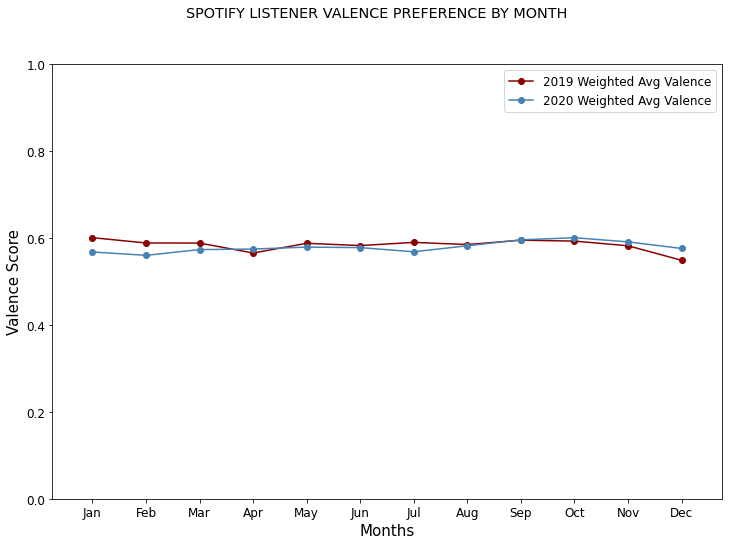

In [46]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019]

valence_2020 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020]
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH')         # Set up main title

y_axis = valence_2019['Valence_Stream%']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence_Stream%'], label="2019 Weighted Avg Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence_Stream%'], label="2020 Weighted Avg Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


In [47]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'New Zealand']   # Filter for country of your choice

country_covid_df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
53824,NZL,Oceania,New Zealand,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53825,NZL,Oceania,New Zealand,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53826,NZL,Oceania,New Zealand,2020-03-01,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53827,NZL,Oceania,New Zealand,2020-03-02,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53828,NZL,Oceania,New Zealand,2020-03-03,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931


In [48]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = country_covid_df[country_covid_df.date.str.contains(r'2020.*')]

country_covid__2020_df['Month'] = ''
country_covid__2020_df.head()

<ipython-input-48-9a7ab2cb5104>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_covid__2020_df['Month'] = ''


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
53824,NZL,Oceania,New Zealand,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53825,NZL,Oceania,New Zealand,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53826,NZL,Oceania,New Zealand,2020-03-01,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53827,NZL,Oceania,New Zealand,2020-03-02,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53828,NZL,Oceania,New Zealand,2020-03-03,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,


In [49]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
53824,NZL,Oceania,New Zealand,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,2
53825,NZL,Oceania,New Zealand,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,2
53826,NZL,Oceania,New Zealand,2020-03-01,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,3
53827,NZL,Oceania,New Zealand,2020-03-02,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,3
53828,NZL,Oceania,New Zealand,2020-03-03,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,3


In [50]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,2,1.0
1,3,646.0
2,4,832.0
3,5,25.0
4,6,24.0
5,7,34.0
6,8,190.0
7,9,96.0
8,10,111.0
9,11,100.0


In [51]:
# TIP: This next section is to add missing months. In the case of New Zealand, there was no data for January
# For other countries, it might vary. Here's how I added January to the dataframe:

country_covid__2020_groupby.loc[-1] = [1, 0]             # This adds a 1 (month of January) in the first columne 
                                                         # index 0), in the last row of the dataframe. 

country_covid__2020_groupby.index = country_covid__2020_groupby.index + 1   # shifts the index
country_covid__2020_groupby = country_covid__2020_groupby.sort_index()      # sorts by index

country_covid__2020_groupby = country_covid__2020_groupby.rename(columns={"new_cases": "New Cases"})

country_covid__2020_groupby


,Month,New Cases
0,1,0.0
1,2,1.0
2,3,646.0
3,4,832.0
4,5,25.0
5,6,24.0
6,7,34.0
7,8,190.0
8,9,96.0
9,10,111.0


In [52]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")

country_covid_valence_df

,Month,Valence_Stream%,New Cases
0,1,0.567577,0.0
1,2,0.559836,1.0
2,3,0.573040,646.0
3,4,0.574266,832.0
4,5,0.578763,25.0
5,6,0.577607,24.0
6,7,0.568057,34.0
7,8,0.581895,190.0
8,9,0.595530,96.0
9,10,0.600335,111.0


In [53]:
# Add a new cases per million column

country_polulation = 5002100  #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

,Month,Valence_Stream%,New Cases,New Cases Per Million
0,1,0.567577,0.0,0.000000
1,2,0.559836,1.0,0.199916
2,3,0.573040,646.0,129.145759
3,4,0.574266,832.0,166.330141
4,5,0.578763,25.0,4.997901
5,6,0.577607,24.0,4.797985
6,7,0.568057,34.0,6.797145
7,8,0.581895,190.0,37.984047
8,9,0.595530,96.0,19.191939
9,10,0.600335,111.0,22.190680


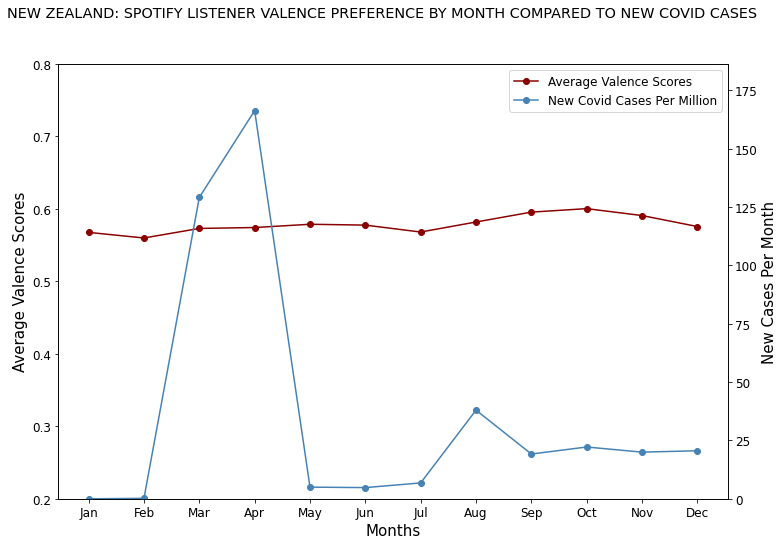

In [55]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('NEW ZEALAND: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence_Stream%']
ax1.plot(months, ax1_ydata, label="Average Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()


In [56]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

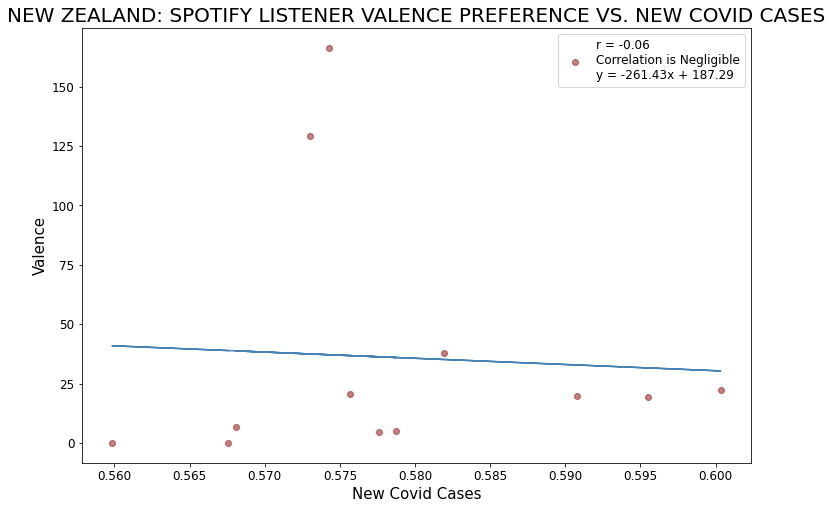

In [57]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence_Stream%']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('NEW ZEALAND: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"New Covid Cases")                                               # Set x axis label for subplot                  
plt.ylabel(f"Valence")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()